In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flatiron-capstone/submission_df.csv
/kaggle/input/flatiron-capstone/train_df.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/sample_submission.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/test/8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/2100032a-7c33-4bff-97ef-690822c43466.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/2f392438-e215-4169-bebf-21ac4ff253e1.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/3f316b38-1a24-45a9-8d8c-4e05a42257c6.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/f8b03c87-9d1a-4f20-b76b-cb6c69d447b2.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/585ba241-6348-41ce-a5d2-c9ee434cd64d.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/bde73ad6-ce46-489b-8ee0-b162698cc6df.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/c7ce1ac6-36e4-4258-b2e4-1

# Libraries

In [2]:
import pandas as pd
import numpy as np
import random
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import os
import re
import json
import glob
from collections import defaultdict
from textblob import TextBlob
from functools import partial
from tqdm.autonotebook import tqdm
import string

from PIL import Image

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
nlp.max_length = 4000000
from spacy.util import compounding
from spacy.util import minibatch

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
#define stopwords
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

# OBTAIN

In [4]:
#read train data
train_df = pd.read_csv('../input/flatiron-capstone/train_df.csv', index_col = 0)
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text,tokenized_text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,this study used data from the national educati...,"['study', 'used', 'data', 'national', 'educati..."
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,dropping out of high school is not necessarily...,"['dropping', 'high', 'school', 'necessarily', ..."
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,stress satisfactory outcomes for all youth inc...,"['stress', 'satisfactory', 'outcomes', 'youth'..."
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,federal reserve bank of richmond s1 accounting...,"['federal', 'reserve', 'bank', 'richmond', 's1..."
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,this article investigates an important factor ...,"['article', 'investigates', 'important', 'fact..."


In [5]:
#read submission data
submission_df = pd.read_csv('../input/flatiron-capstone/submission_df.csv', index_col = 0)
submission_df.head()

,Id,PredictionString,text
0,2100032a-7c33-4bff-97ef-690822c43466,NaN,Cognitive deficits and reduced educational ach...
1,2f392438-e215-4169-bebf-21ac4ff253e1,NaN,This report describes how the education system...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,NaN,"Cape Hatteras National Seashore (CAHA), locate..."
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,NaN,A significant body of research has been conduc...


# Preprocessing

Preprocessing text data is a bit more challenging that working with more traditional data types because there's no clear-cut answer for exactly what sort of preprocessing and cleaning we need to do. Before we can begin cleaning and preprocessing our text data, we need to make some decisions about things such as:

* Do we remove stop words or not?
* Do we stem or lemmatize our text data, or leave the words as is?
* Is basic tokenization enough, or do we need to support special edge cases through the use of regex?
* Do we use the entire vocabulary, or just limit the model to a subset of the most frequently used words? If so, how many?
* Do we engineer other features, such as bigrams, or POS tags, or Mutual Information Scores?
* What sort of vectorization should we use in our model? Boolean Vectorization? Count Vectorization? TF-IDF? More advanced vectorization strategies such as Word2Vec?

### Count Vectorization

Machine Learning algorithms don't understand strings. However, they do understand math, which means they understand vectors and matrices. By Vectorizing the text, we just convert the entire text into a vector, where each element in the vector represents a different word. The vector is the length of the entire vocabulary -- usually, every word that occurs in the English language, or at least every word that appears in our corpus. Any given sentence can then be represented as a vector where all the vector is 1 (or some other value) for each time that word appears in the sentence.

### TD-IDF Vectorization

TD-IDF is short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.

**Count Vectorizer give number of frequency with respect to index of vocabulary where as tf-idf consider overall documents of weight of words.**

## Regex

## POS Tags

## Mutual Information Scores

# FEATURES ENGINEERING

## BiGram

An n-gram means a sequence of n-words.

Some English words occur together more frequently. So, in a text document we may need to identify such pair of words which will help in sentiment analysis. 

Bigram is 2 consecutive words in a sentence.

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

#get bigrams 
vectorizer = CountVectorizer(ngram_range = (2, 2))

#matrix of ngrams
ngrams = vectorizer.fit_transform(train_df['cleaned_label']) 
features = (vectorizer.get_feature_names())
print('\n\nFeatures : \n', features)

#count frequency of ngrams
print('\n\nX1 : \n', ngrams.toarray())
  
#apply TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (2, 2))
ngrams = vectorizer.fit_transform(train_df['cleaned_label'])
scores = (ngrams.toarray())
print('\n\nScores : \n', scores)
  
#get top ranking features
sums = ngrams.sum(axis = 0)
data1 = []
for col, term in enumerate(features):
    data1.append( (term, sums[0,col] ))
ranking = pd.DataFrame(data1, columns = ['term','rank'])
words = (ranking.sort_values('rank', ascending = False))
print ('\n\nWords head : \n', words.head(60))



Features : 
 ['19 antiviral', '19 control', '19 dataset', '19 death', '19 genome', '19 image', '19 open', '2019 ncov', 'administration cap', 'administration optimum', 'administration world', 'adult competencies', 'advanced national', 'aging blsa', 'aging genetics', 'aging integrated', 'agricultural resource', 'agricultural resources', 'alzheimer disease', 'alzheimers disease', 'american breeding', 'analysis program', 'and atmospheric', 'and beyond', 'and crop', 'and development', 'and engineering', 'and overland', 'and postdoctorates', 'and principal', 'and safety', 'and science', 'and your', 'anss comprehensive', 'antiviral candidate', 'archive for', 'arms farm', 'assessment of', 'associated risks', 'atmospheric administration', 'baccalaureate and', 'baltimore longitudinal', 'baseline disease', 'beginning postsecondary', 'best track', 'beyond longitudinal', 'bird survey', 'breeding bird', 'candidate compounds', 'cas covid', 'catalog comcat', 'census of', 'center for', 'change analys

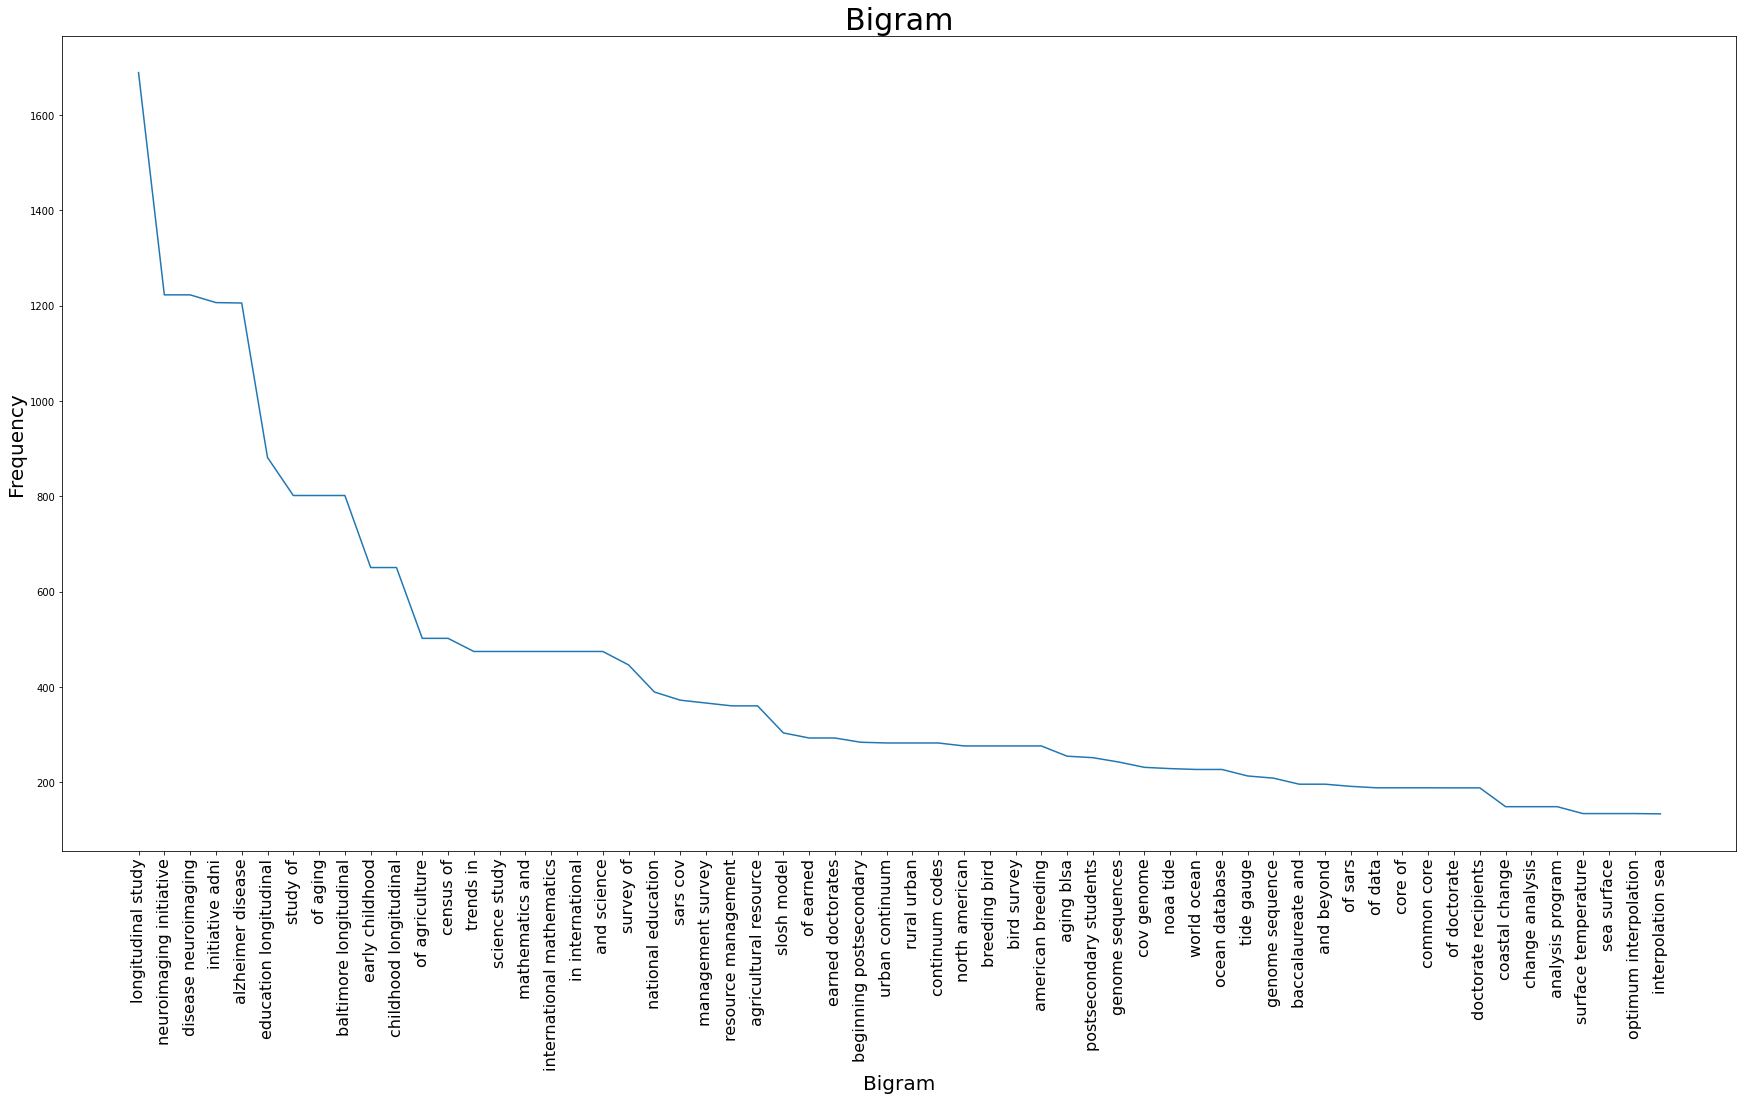

<Figure size 432x288 with 0 Axes>

In [40]:
#count frequency of ngrams
count_values = ngrams.toarray().sum(axis = 0)

#list of ngrams
vocab = vectorizer.vocabulary_
df_bigram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse = True)
            ).rename(columns = {0: 'frequency', 1:'bigram'})

plt.figure(figsize = (30, 15))
sns.lineplot(x = df_bigram['bigram'][:60], y = df_bigram['frequency'][:60])
plt.xticks(rotation = 90, fontsize = 16)
plt.xlabel('Bigram',fontsize = 20)
plt.ylabel('Frequency',fontsize = 20)
plt.title('Bigram',fontsize = 30)
plt.show()

#save
plt.savefig('bigram.png')

## TriGram

Trigram is 3 consecutive words in a sentence. 

In [41]:
#get trigrams 
vectorizer = CountVectorizer(ngram_range = (3,3))

#matrix of ngrams
ngrams = vectorizer.fit_transform(train_df['cleaned_label']) 
features = (vectorizer.get_feature_names())
print('\n\nFeatures : \n', features)

#count frequency of ngrams
print('\n\nX1 : \n', ngrams.toarray())
  
#apply TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (3,3))
ngrams = vectorizer.fit_transform(train_df['cleaned_label'])
scores = (ngrams.toarray())
print('\n\nScores : \n', scores)
  
#get top ranking features
sums = ngrams.sum(axis = 0)
data1 = []
for col, term in enumerate(features):
    data1.append( (term, sums[0,col] ))
ranking = pd.DataFrame(data1, columns = ['term','rank'])
words = (ranking.sort_values('rank', ascending = False))
print ('\n\nWords head : \n', words.head(60))



Features : 
 ['19 antiviral candidate', '19 control strategies', '19 death data', '19 genome sequence', '19 genome sequences', '19 image data', '19 open radiology', '19 open research', '2019 ncov complete', '2019 ncov genome', 'administration optimum interpolation', 'administration world ocean', 'advanced national seismic', 'aging genetics of', 'aging integrated database', 'agricultural resource management', 'agricultural resources management', 'alzheimer disease data', 'alzheimer disease neuroimaging', 'alzheimers disease neuroimaging', 'american breeding bird', 'analysis program land', 'and atmospheric administration', 'and beyond longitudinal', 'and crop production', 'and development survey', 'and engineering research', 'and engineering statistics', 'and overland surges', 'and postdoctorates in', 'and principal survey', 'and science study', 'and your baseline', 'anss comprehensive catalog', 'anss comprehensive earthquake', 'antiviral candidate compounds', 'archive for climate', 'a

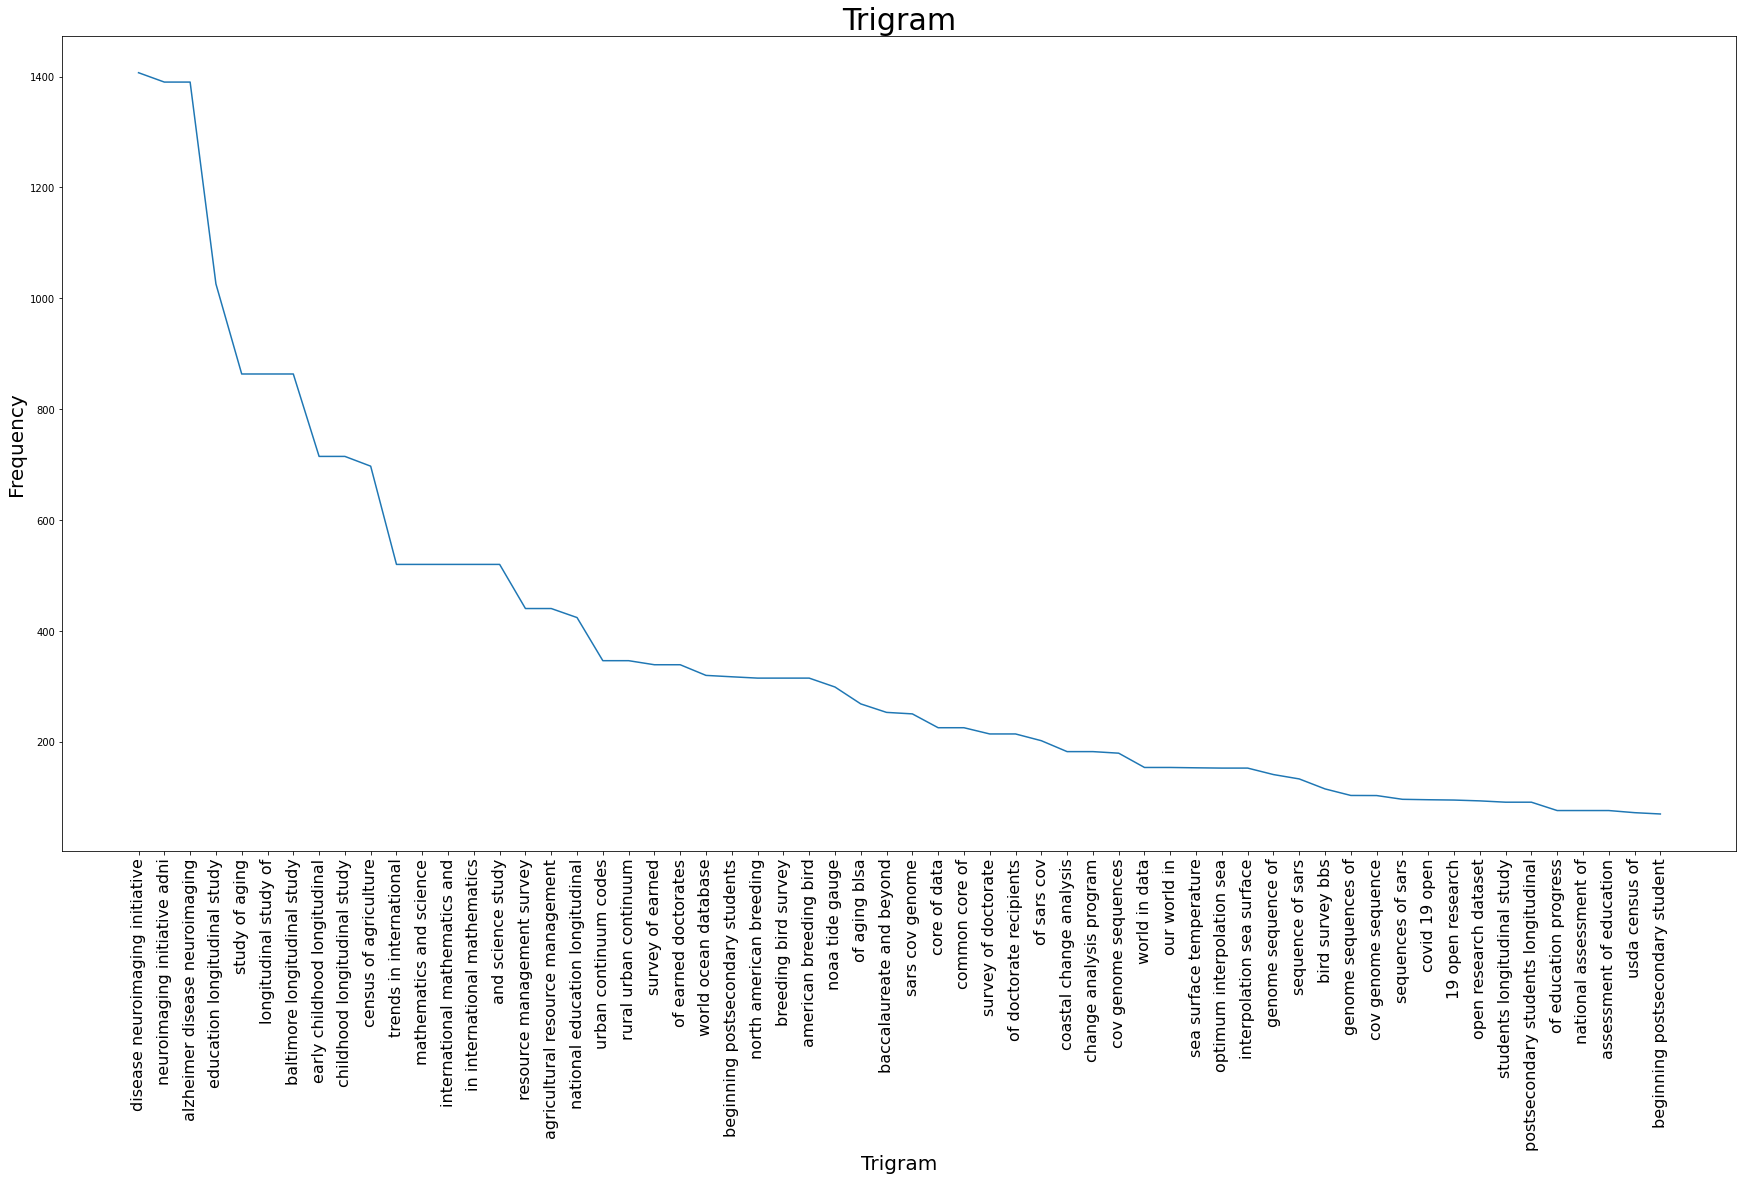

<Figure size 432x288 with 0 Axes>

In [42]:
#count frequency of ngrams
count_values = ngrams.toarray().sum(axis = 0)

#list of ngrams
vocab = vectorizer.vocabulary_
df_trigram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse = True)
            ).rename(columns = {0: 'frequency', 1:'trigram'})

plt.figure(figsize = (30, 15))
sns.lineplot(x = df_trigram['trigram'][:60], y = df_trigram['frequency'][:60])
plt.xticks(rotation = 90, fontsize = 16)
plt.xlabel('Trigram',fontsize = 20)
plt.ylabel('Frequency',fontsize = 20)
plt.title('Trigram',fontsize = 30)
plt.show()

#save
plt.savefig('trigram.png')

# TITLE MATCHING

## Train-Test-Split

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(train_df, test_size=0.25, random_state=123)
print('Train size:', train.shape)
print('Test size:', test.shape)

## MODELING

### MultinomialNB

In [ ]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()

In [ ]:
nb_classifier.fit(train.data, train.target)
nb_train_preds = nb_classifier.predict(tf_idf_data_train)
nb_test_preds = nb_classifier.predict(tf_idf_data_test)

In [ ]:
nb_train_score = accuracy_score(target, nb_train_preds)
nb_test_score = accuracy_score(newsgroups_test.target, nb_test_preds)

## Random Forest

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100)

In [ ]:
rf_classifier.fit(tf_idf_data_train, target)
rf_train_preds = rf_classifier.predict(tf_idf_data_train)
rf_test_preds = rf_classifier.predict(tf_idf_data_test)

In [ ]:
rf_train_score = accuracy_score(target, rf_train_preds)
rf_test_score = accuracy_score(newsgroups_test.target, rf_test_preds)

## k-mean Clustering
Adapted from https://www.kaggle.com/ahmedewida/coleridge-eda-kmeans#6.-Modelling

In [43]:
from sklearn.cluster import MiniBatchKMeans

#implementing TFIDF 
vectorizer = TfidfVectorizer(max_features = 5000)
X = vectorizer.fit_transform(train_df['text'].values)

#implementing K-Means
k = 9
kmeans = MiniBatchKMeans(n_clusters = k)
y_pred = kmeans.fit_predict(X)

#reduce dimensionality
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
pca_result = pca.fit_transform(X.toarray())
            
print(pca.components_)
print(pca.explained_variance_)

[[ 0.00365319  0.01694929 -0.00299761 ... -0.00211266 -0.00144133
  -0.00010301]
 [ 0.00104684 -0.00126558  0.00656556 ... -0.00454924 -0.0045785
  -0.00206772]
 [ 0.00378371  0.00705912 -0.00285555 ...  0.00315642  0.00599394
   0.00358696]]
[0.02356948 0.01985305 0.014976  ]


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


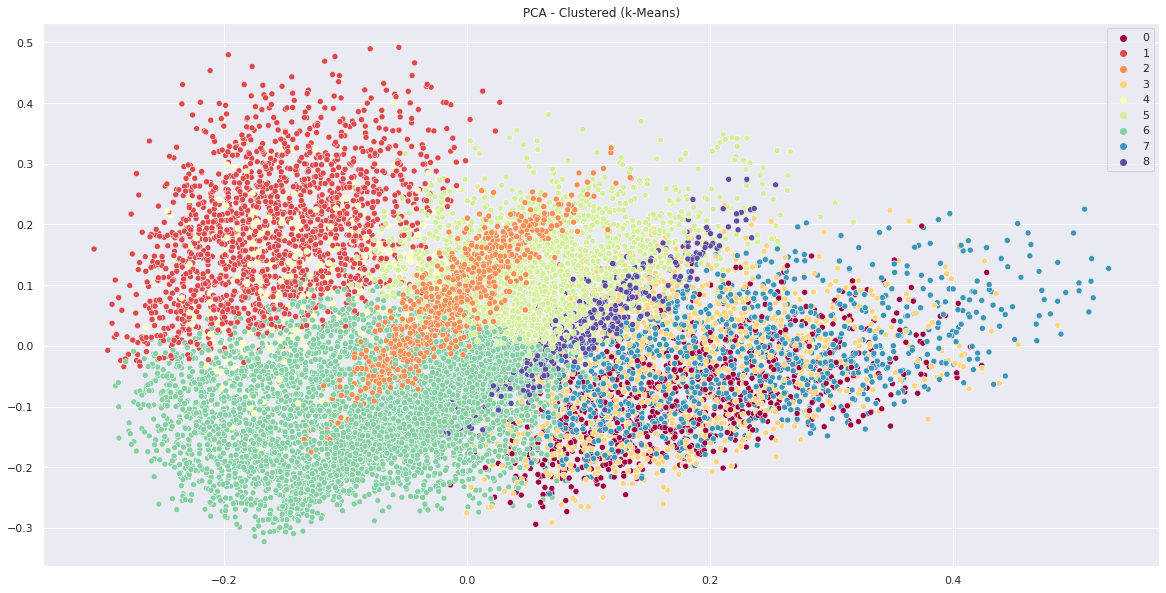

In [60]:
#plot K-Means Clustering
plt.figure(figsize = (20, 10))
sns.scatterplot(pca_result[:,0], pca_result[:,1], 
                hue = y_pred,sizes = 100, 
                legend = 'full',
                palette = 'Spectral')
plt.title('PCA - Clustered (k-Means)')

#save
plt.savefig('kmean_clustering.png')

1
0.05581259727478027
2
0.05459308624267578
3
0.052720069885253906
4
0.11464190483093262
5
0.12127995491027832
6
0.06226825714111328
7
0.061022043228149414
8
0.17628073692321777
9
0.22027182579040527
10
0.06346702575683594
11
0.17816519737243652
12
0.2240920066833496
13
0.17215228080749512
14
0.15578269958496094
15
0.26290297508239746
16
0.10282206535339355
17
0.07589888572692871
18
0.0908660888671875
19
0.08286619186401367


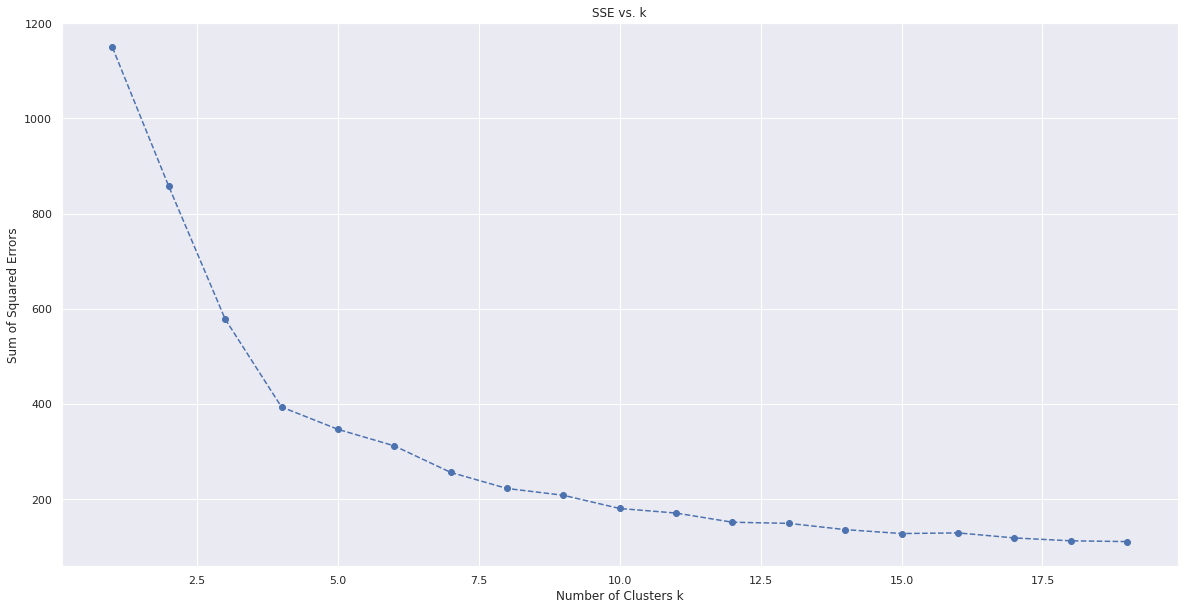

In [59]:
#get the best number of clusters using elbow method
import time

def elbow_plot(data, start_K, end_K, step):
    '''
    Generate an elbow plot to find optimal number of clusters
    graphing K values from start_K to end_K every step value
    
    INPUT: 
        data: Demographics DataFrame
        start_K: Inclusive starting value for cluster number
        end_K: Exclusive stopping value for cluster number
        step: Step value between start_K and end_K
    OUTPUT: Trimmed and cleaned demographics DataFrame
    '''
    score_list = []

    for i in range(start_K, end_K, step):
        print(i)
        start = time.time()
        kmeans = MiniBatchKMeans(i)
        model = kmeans.fit(data)
        score = model.score(data)
        score_list.append(abs(score))
        end = time.time()
        elapsed_time = end - start
        print(elapsed_time)

    plt.figure(figsize = (20, 10))
    plt.plot(range(start_K, end_K, step),
             score_list, linestyle = '--', marker = 'o', color = 'b');
    plt.xlabel('Number of Clusters k');
    plt.ylabel('Sum of Squared Errors');
    plt.title('SSE vs. k');
    plt.savefig('elbow_plot.png')
    
elbow_plot(pca_result, 1, 20, 1)

#save
plt.savefig('elbow_plot.png')

## Deep Learning

### Word Embedding

Word Embeddings are a type of vectorization strategy that computes word vectors from a text corpus by training a neural network, which results in a high-dimensional embedding space, where each word in the corpus is a unique vector in that space. In this embedding space, the position of the vector relative to the other vectors captures semantic meaning. This method of creating distributed representations of words in a high-dimensional embedding space was first introduced in a landmark paper from members of the Google Brain team in 2013 at the Neural Information Processing Systems (NeurIPS, for short).

So far, the vectorization strategies you've learned have focused only on how often a word appears in a given text, but they don't focus at all on capturing the semantic meaning. This is one area where using the Word2Vec model to create Word Vector Embeddings really shines, because it will capture those semantic relationships between words, for instance, a Word2Vec model that is given enough data and training will learn that there is a semantic relationship between the word 'person' and 'people'. Furthermore, vector one would need to travel to get from the singular 'person' to the plural 'people' will be the same vector that will get you from the singular version of a word to it's plural - meaning that our model will 'learn' how to model the relationship between singular and plural versions of the same word. 

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length, # set input shape
                             output_dim = 128, # set size of embedding vector
                             embeddings_initializer='uniform', # default, intialize randomly
                             input_length = max_length) # how long is each input

embedding

### Word2Vec

Word2Vec is just another deep neural network. It's not even a particularly complex neural network -- the model contains an input layer, a single hidden layer, and and an output layer that uses the softmax activation function, meaning that the model is meant for multiclass classification. The model examines a window of words, which is a tunable parameter that you can set when working with the model.

In [ ]:
from gensim.models import phrases, word2vec

#create a large corpus for training
sentences = train_df['text'].values

#use gensim's phrases to find bigrams
bigrams = phrases.Phrases(sentences)

In [ ]:
bigrams[sentences]

model = word2vec.Word2Vec(bigrams[sentences], min_count = 3)

In [ ]:
vocab = list(model.wv.key_to_index)
len(vocab)

In [ ]:
X = model.wv[vocab]

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3, random_state = 123, whiten = True)

clf = pca.fit_transform(X)

tmp = pd.DataFrame(clf, index=vocab, columns = ['x', 'y', 'z'])

tmp.head(3)

In [ ]:
tmp = tmp.sample(150)

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(tmp['x'], tmp['y'], tmp['z'], alpha = 0.5)

for word, row in tmp.iterrows():
    x, y, z = row
    pos = (x, y, z)
    ax.text(x, y, z, s = word, size=8, zorder = 1, color = 'k')
    
plt.title('w2v map - PCA')
plt.show()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components = 3, random_state = 123)

clf = tsne.fit_transform(X)

tmp = pd.DataFrame(clf, index=vocab, columns=['x', 'y', 'z'])

tmp.head(3)

In [ ]:
tmp = tmp.sample(150)

In [ ]:
fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(tmp['x'], tmp['y'], tmp['z'], alpha = 0.5)

for word, row in tmp.iterrows():
    x, y, z = row
    pos = (x, y, z)
    ax.text(x, y, z, s=word, size=8, zorder=1, color = 'k')
    
plt.title('w2v map - t-SNE')
plt.show()

### Skip-Gram Architecture

The most clever thing about the Word2Vec model is the type of problem it trains the network to solve, which creates the dense vectors for every word as a side effect! A typical task for a neural network is sentence completion. A trained model should be able to take in a sentence like "the cat sat on the" and output the most likely next word in the sentence, which should be something like "mat", or "floor". This is a form of Sequence Generation. Given a certain context (the words that came before), the model should be able to generate the next most plausible word (or words) in the sequence.

Word2Vec takes this idea, and flips it on its head. Instead of predicting the next word given a context, the model trains to predict the context surrounding a given word! This means that given the example word "fox" from above, the model should learn to predict the words "quick", "brown", "jumps", and "over", although crucially, not in any particular order. You're likely asking yourself why a model like this would be useful -- there are a massive amount of correct contexts that can surround a given word, which means that the output trained model itself likely isn't very useful to us. This intuition is correct -- the output of the model is pretty useless to us. However, in the case of Word2Vec, it's not the model that we're interested in. It turns out that by training to predict the context window for a given word, the neurons in the hidden layer end up learning the embedding space! This is the reason why the size of the word vectors output by a Word2Vec model are a parameter that you can set ourselves. If you want word vectors of size 300, then you just include 300 neurons in our hidden layer. If you want vectors of size 100, then you include 100 neurons, and so on. Take a look at the following diagram of the Word2Vec model's architecture:

### Using Pretrained Word Vectors With GloVe

In [ ]:
total_vocabulary = set(word for cleaned_label in train_df['cleaned_label'] for word in train_df['cleaned_label'])

len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

# INTERPRETATION

### Cosine similarity function

In [ ]:
#code from https://www.kaggle.com/adnaiksachin25/wordcloud-cosine-jaccard-sequencematcher
from nltk.tokenize import word_tokenize

def cosine(train, test):
    """
    Enter text one from each train and test set for cosine similarity
    """
    sw = stopwords_list
    X_list = word_tokenize(train)
    Y_list = word_tokenize(test)
    l1 = []; l2 = []
    
    # remove stop words from the string
    X_set = {w for w in X_list if not w in sw} 
    Y_set = {w for w in Y_list if not w in sw}
    
    # form a set containing keywords of both strings 
    rvector = X_set.union(Y_set) 
    for w in rvector:
        if w in X_set: l1.append(1) # create a vector
        else: l1.append(0)
        if w in Y_set: l2.append(1)
        else: l2.append(0)
    c = 0
    
        # cosine formula 
    for i in range(len(rvector)):
        c += l1[i] * l2[i]
    cosine = c / float((sum(l1) * sum(l2)) ** 0.5)
    return cosine

In [ ]:
for j in range(0, len(submission_df['text'])):
    print('Similarity of first train text with text {} from test data'.format(j))
    print(cosine(train_df['text'][0], submission_df.loc[j,'text']))

In [ ]:
for j in range(0, len(submission_df['text'])):
    print('Similarity of second train text with text {} from test data'.format(j))
    print(cosine(train_df['text'][1], submission_df.loc[j,'text']))

### Jaccard similarity

In [ ]:
#code from https://www.kaggle.com/adnaiksachin25/wordcloud-cosine-jaccard-sequencematcher

def jaccard_similarity(text_a, text_b):
    word_set_a, word_set_b = [set(text.split())
                              for text in [text_a, text_b]]
    num_shared = len(word_set_a & word_set_b)
    num_total = len(word_set_a | word_set_b)
    return num_shared / num_total


In [ ]:
for j in range(0,len(submission_df['text'])):
    print('Similarity of first train text with text {} from test data'.format(j))
    similarity = jaccard_similarity(submission_df.loc[j,'text'], train_df['text'][0])
    print(similarity)

In [ ]:
for j in range(0,len(submission_df['text'])):
    print('Similarity of second train text with text {} from test data'.format(j))
    similarity = jaccard_similarity(submission_df.loc[j,'text'], train_df['text'][1])
    print(similarity)

In [ ]:
#evaluate it using the metric that they use in this dataset
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
import itertools    
import collections

max = 1500

L_word = []
for i in range(max):
    L_word += list(train_df.text[i].split())
print(len(L_word))

L_new = []
for x in L_word:
    if x not in stopwords_list:
        if len(x) > 2:
            L_new.append(x)
print(len(L_new))

words = [L_new]
all_words = list(itertools.chain(*words))

counts_words = collections.Counter(all_words)

counts_words.most_common(15)

In [ ]:
max_len = 19661
L_labels = []
for i in range(max_len):
    L_labels += list(train_df.dataset_label[i].split())
print(len(L_labels))

L_new_lab = []
for x in L_labels:
    if x not in stopwords_list:
        if len(x) > 2:
            L_new_lab.append(x)
print(len(L_new_lab))

labels = [L_new_lab]

counts_labels = collections.Counter(list(itertools.chain(*labels)))

len(counts_labels.most_common())

In [ ]:
def extract(L):
    most = []
    for x in L:
        most.append(x[0])
    return most

maxi = 2000

most_frequent = extract(counts_labels.most_common(maxi)) + extract(counts_words.most_common(maxi))
print(len(counts_labels.most_common(maxi)))
print(len(counts_words.most_common(maxi)))
print(len(most_frequent))

In [ ]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()


L_sub = []
for i in range(len(submission_df.text)):
    L_sub += list((submission_df.text[i].split()))
print(len(L_sub))

L_new_sub = []
for x in L_sub:
    if x not in stopwords_list:
        if len(x) > 2:
            L_new_sub.append(clean_text(x))
print(len(L_new_sub))

wordd = [L_new_sub]
all_sub = list(itertools.chain(*wordd))

counts_sub = collections.Counter(all_sub)

most = extract(counts_sub.most_common(maxi))

counts_sub.most_common(15)

In [ ]:
temp_1 = [x.lower() for x in train_df['dataset_label'].unique()]
temp_2 = [x.lower() for x in train_df['dataset_title'].unique()]
temp_3 = [x.lower() for x in train_df['cleaned_label'].unique()]
existing_labels = set(temp_1 + temp_2 + temp_3)

def predict(sample_sub):
    id_list = []
    lables_list = []
    for index, row in tqdm(submission_df.iterrows()):
        sample_text = row['text']
        row_id = row['Id']
        temp_df = train_df[train_df['text'] == clean_text(sample_text)]
        cleaned_labels = temp_df['cleaned_label'].to_list()
        for known_label in existing_labels:
            if known_label in sample_text.lower():
                if known_label not in stopwords_list:
                    if len(known_label)>1:
                        if known_label in most:
                            cleaned_labels.append(clean_text(known_label))
        cleaned_labels = [clean_text(x) for x in cleaned_labels]
        cleaned_labels = set(cleaned_labels)
        lables_list.append('|'.join(cleaned_labels))
        id_list.append(row_id)
    return (id_list,lables_list)

In [ ]:
Z = predict(submission_df)
submission = pd.DataFrame()
submission['Id'] = Z[0]
submission['PredictionString'] = Z[1]
submission

In [ ]:
X = predict(train_df.head(1000))[1]
score = []

for i in range(len(X)):
    score.append(jaccard_similarity(X[i], train_df.dataset_label[i]))
print(f'Score is : {np.mean(score)}')

In [ ]:
submission.to_csv(r'submission.csv',index = None)

### SequenceMatcher

In [ ]:
#code from https://www.kaggle.com/adnaiksachin25/wordcloud-cosine-jaccard-sequencematcher

import difflib

for j in range(0,len(submission_df['text'])):
    print('Similarity of first train text with text {} from test data'.format(j))
    d = difflib.SequenceMatcher(None, submission_df.loc[j,'text'], train_df['text'][0])
    similarity = d.ratio()*100
    print(similarity)

In [ ]:
for j in range(0,len(submission_df['text'])):
    print('Similarity of second train text with text {} from test data'.format(j))
    d = difflib.SequenceMatcher(None, submission_df.loc[j,'text'], train_df['text'][1])
    similarity = d.ratio() * 100
    print(similarity)